In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Hugging Face datasets
from datasets import load_dataset

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Models
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier

sns.set(style='whitegrid')

/Users/Daniel/anaconda3/envs/emotion_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load GoEmotions dataset
dataset = load_dataset("go_emotions")

# Convert to DataFrame and keep single-label entries
label_names = dataset['train'].features['labels'].feature.names
df = pd.DataFrame(dataset['train'])
df_single = df[df['labels'].apply(lambda x: len(x) == 1)].copy()
df_single['label'] = df_single['labels'].apply(lambda x: x[0])
df_single['label_name'] = df_single['label'].apply(lambda i: label_names[i])

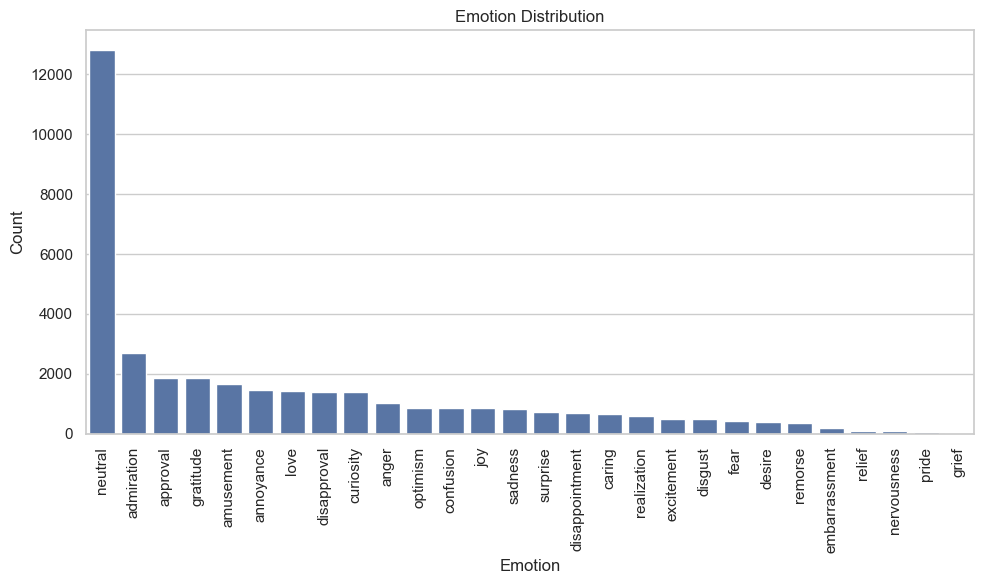

In [3]:
# Emotion distribution 
plt.figure(figsize=(10, 6))

sns.countplot(
    x='label_name',
    data=df_single,
    order=df_single['label_name'].value_counts().index
)

plt.title("Emotion Distribution")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

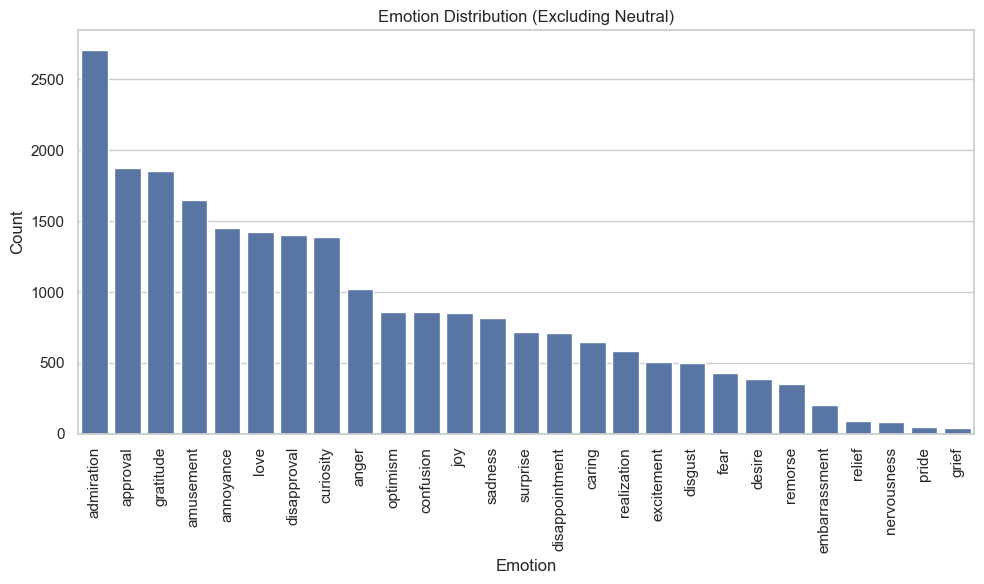

In [4]:
# Emotion distribution WITHOUT neutral
plt.figure(figsize=(10, 6))
df_no_neutral = df_single[df_single['label_name'] != 'neutral']

sns.countplot(
    x='label_name',
    data=df_no_neutral,
    order=df_no_neutral['label_name'].value_counts().index
)

plt.title("Emotion Distribution (Excluding Neutral)")
plt.xlabel("Emotion")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [5]:
# To avoid too much repetition
def train_eval_pipeline(df, title=""):
    print(f"\nRunning pipeline: {title}\n{'='*60}")

    # Vectorization
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(df['text'])
    y = df['label']

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

    # Models
    models = {
        'Linear SVM': LinearSVC(class_weight='balanced'),
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced', max_iter=1000),
        'MLP Classifier': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    }

    results = {}

    for name, clf in models.items():
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)

        # Compute Macro F1
        macro_f1 = f1_score(y_test, preds, average='macro')
        results[name] = macro_f1

        # Print classification summary
        print(f"{name} - Macro F1: {macro_f1:.3f}")

        # Confusion Matrix heatmap (top 10 classes only)
        top_labels = df['label'].value_counts().nlargest(10).index
        top_names = [label_names[i] for i in top_labels]

        mask = np.isin(y_test, top_labels)
        cm = confusion_matrix(y_test[mask], preds[mask], labels=top_labels, normalize='true')

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, xticklabels=top_names, yticklabels=top_names, annot=True, fmt=".2f", cmap='Blues')
        plt.title(f"{name} Confusion Matrix ({title}) - Top 10 Emotions")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()
        
        print_most_confused_pairs(y_test, preds, label_names)
        plot_confidence_histogram(clf, X_test, name)

    # Model Rankings
    rankings = pd.Series(results).sort_values(ascending=False)
    rankings.plot(kind='bar', figsize=(8,5), title=f"Model Rankings by Macro F1 ({title})", color='skyblue')
    plt.ylabel('Macro F1 Score')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()

    return results


def print_most_confused_pairs(y_test, y_pred, label_names, top_n=3):
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    np.fill_diagonal(cm, 0)
    
    pairs = []
    for _ in range(top_n):
        i, j = np.unravel_index(np.argmax(cm), cm.shape)
        pairs.append((label_names[i], label_names[j], cm[i, j]))
        cm[i, j] = 0  # remove to find next
    
    print("Top Confused Class Pairs:")
    for true_label, pred_label, val in pairs:
        print(f"{true_label} ➜ {pred_label}: {val:.2%} of the time")


def plot_confidence_histogram(model, X_test, model_name):
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)
        confidences = probs.max(axis=1)
        
        plt.figure(figsize=(8, 5))
        plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
        plt.title(f"{model_name} - Prediction Confidence Histogram")
        plt.xlabel("Confidence (Max Probability)")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

In [6]:
# To avoid too much repetition
def train_eval_pipeline(df, title=""):
    print(f"\nRunning pipeline: {title}\n{'='*60}")

    # Vectorization
    vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
    X = vectorizer.fit_transform(df['text'])
    y = df['label']
    label_names = sorted(df['label'].unique())

    # Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

    # Models
    models = {
        'Linear SVM': LinearSVC(class_weight='balanced'),
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(multi_class='multinomial', solver='lbfgs', class_weight='balanced', max_iter=1000),
        'MLP Classifier': MLPClassifier(hidden_layer_sizes=(100,), max_iter=500, random_state=42)
    }

    results = {}

    for name, clf in models.items():
        clf.fit(X_train, y_train)
        preds = clf.predict(X_test)

        # Compute Macro F1 and other tests
        macro_f1 = f1_score(y_test, preds, average='macro')
        results[name] = {
                        'Macro F1': f1_score(y_test, preds, average='macro'),
                        'Accuracy': accuracy_score(y_test, preds),
                        'Macro Precision': precision_score(y_test, preds, average='macro', zero_division=0),
                        'Macro Recall': recall_score(y_test, preds, average='macro', zero_division=0)
                    }

        # Print classification summary
        print(f"{name} - Macro F1: {macro_f1:.3f}")

        # Confusion Matrix heatmap (top 10 classes only)
        top_labels = df['label'].value_counts().nlargest(10).index
        top_names = top_labels

        mask = np.isin(y_test, top_labels)
        cm = confusion_matrix(y_test[mask], preds[mask], labels=top_labels, normalize='true')

        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, xticklabels=top_names, yticklabels=top_names, annot=True, fmt=".2f", cmap='Blues')
        plt.title(f"{name} Confusion Matrix ({title})")
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        plt.show()
        
        print_most_confused_pairs(y_test, preds, label_names)
        plot_confidence_histogram(clf, X_test, name)

    # Convert results to DataFrame
    results_df = pd.DataFrame(results).T
    
    # Plot rankings by Macro F1
    rankings = results_df['Macro F1'].sort_values(ascending=False)
    rankings.plot(kind='bar', figsize=(8,5), title=f"Model Rankings by Macro F1 ({title})", color='skyblue')
    plt.ylabel('Macro F1 Score')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
    

    return pd.DataFrame(results).T


def print_most_confused_pairs(y_test, y_pred, label_names, top_n=3):
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    np.fill_diagonal(cm, 0)
    
    pairs = []
    for _ in range(top_n):
        i, j = np.unravel_index(np.argmax(cm), cm.shape)
        pairs.append((label_names[i], label_names[j], cm[i, j]))
        cm[i, j] = 0  # remove to find next
    
    print("Top Confused Class Pairs:")
    for true_label, pred_label, val in pairs:
        print(f"{true_label} ➜ {pred_label}: {val:.2%} of the time")


def plot_confidence_histogram(model, X_test, model_name):
    if hasattr(model, "predict_proba"):
        probs = model.predict_proba(X_test)
        confidences = probs.max(axis=1)
        
        plt.figure(figsize=(8, 5))
        plt.hist(confidences, bins=20, color='skyblue', edgecolor='black')
        plt.title(f"{model_name} - Prediction Confidence Histogram")
        plt.xlabel("Confidence (Max Probability)")
        plt.ylabel("Frequency")
        plt.tight_layout()
        plt.show()

### Below we run both pipelines


Running pipeline: All Labels (Including Neutral)
Linear SVM - Macro F1: 0.294


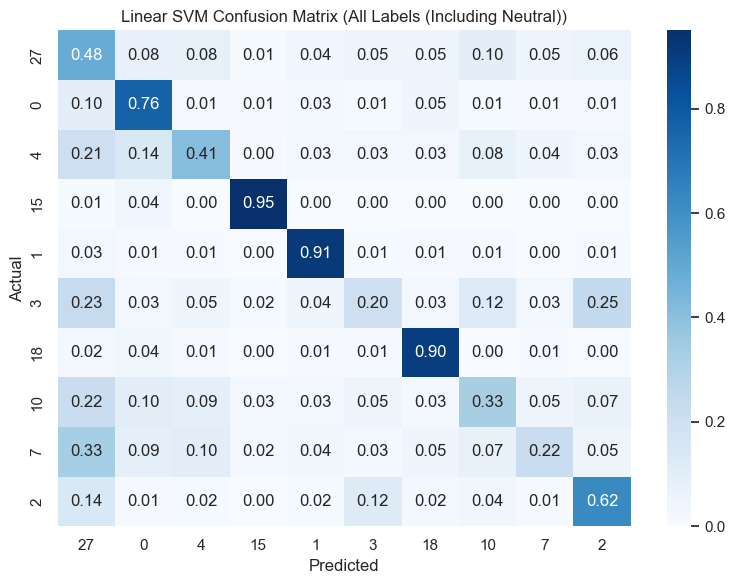

Top Confused Class Pairs:
16 ➜ 14: 30.00% of the time
23 ➜ 17: 22.73% of the time
16 ➜ 27: 20.00% of the time
Naive Bayes - Macro F1: 0.156


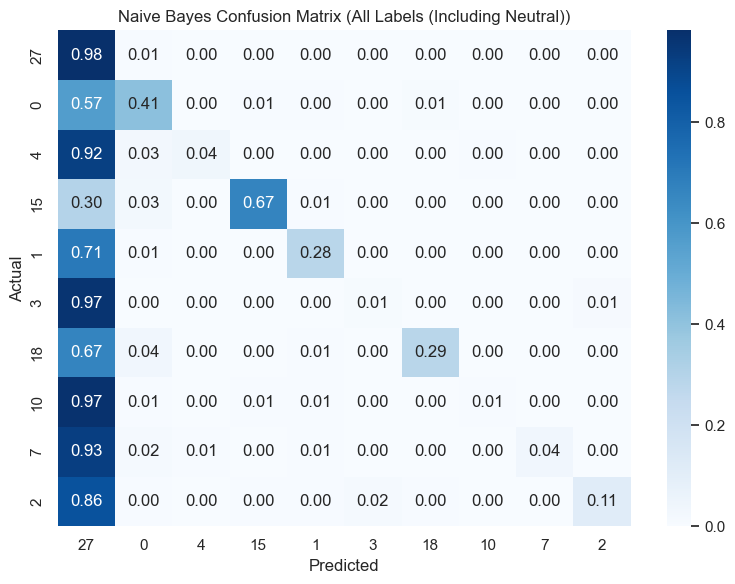

Top Confused Class Pairs:
16 ➜ 27: 100.00% of the time
19 ➜ 27: 100.00% of the time
22 ➜ 27: 99.32% of the time


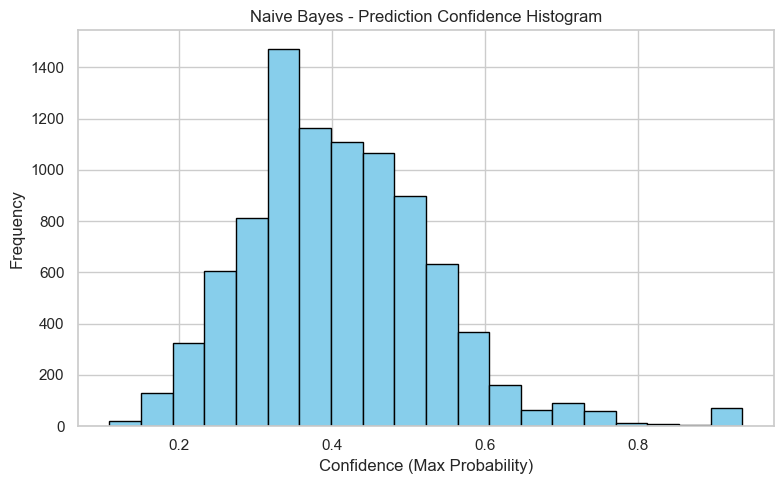

/Users/Daniel/anaconda3/envs/emotion_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression - Macro F1: 0.315


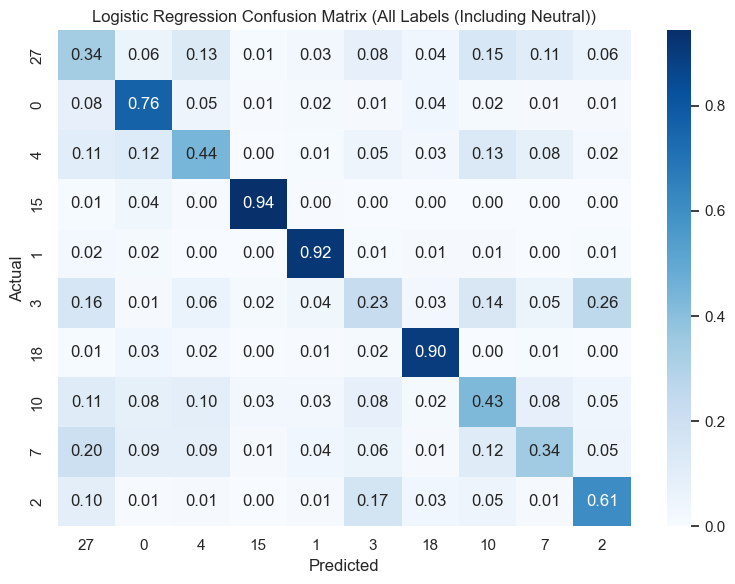

Top Confused Class Pairs:
16 ➜ 14: 30.00% of the time
21 ➜ 17: 15.38% of the time
12 ➜ 22: 13.73% of the time


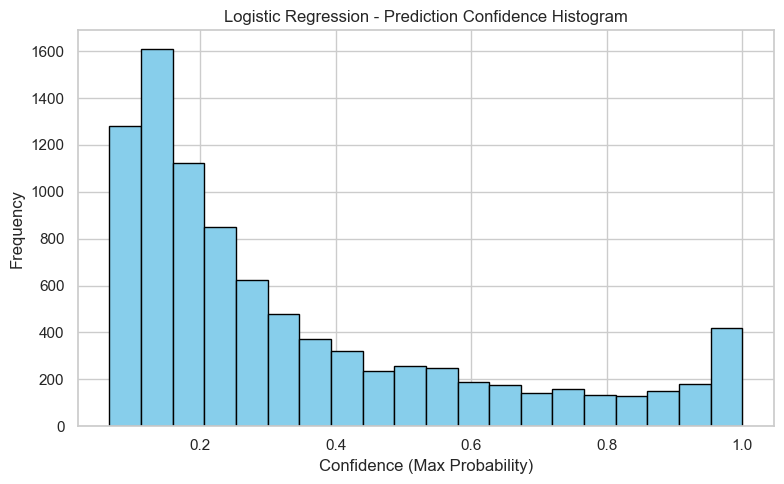

MLP Classifier - Macro F1: 0.273


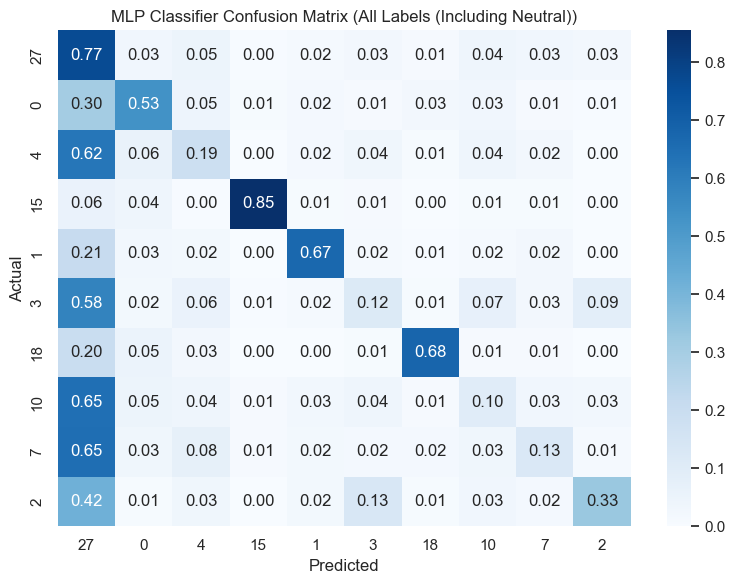

Top Confused Class Pairs:
16 ➜ 27: 70.00% of the time
10 ➜ 27: 55.56% of the time
4 ➜ 27: 55.34% of the time


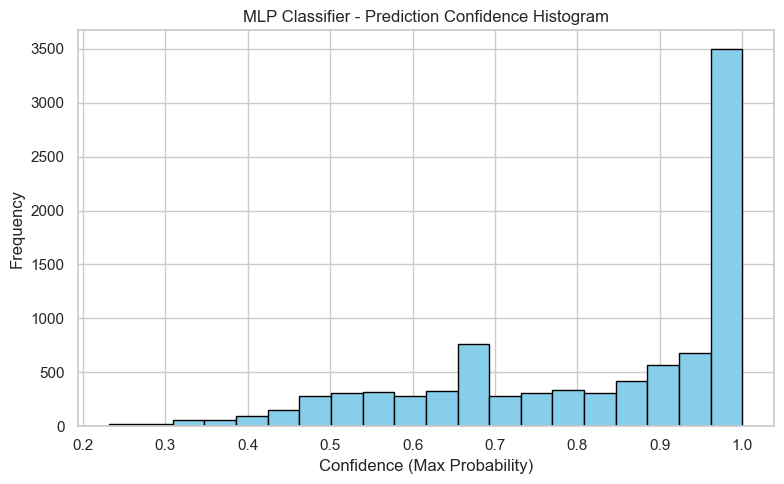

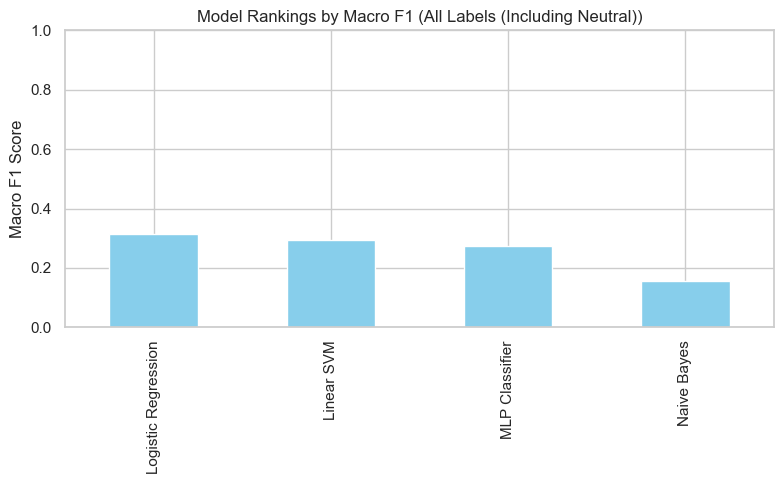

In [7]:
# Pipeline A: All labels
df_results_all = train_eval_pipeline(df_single, title="All Labels")


Running pipeline: Neutral Excluded
Linear SVM - Macro F1: 0.366


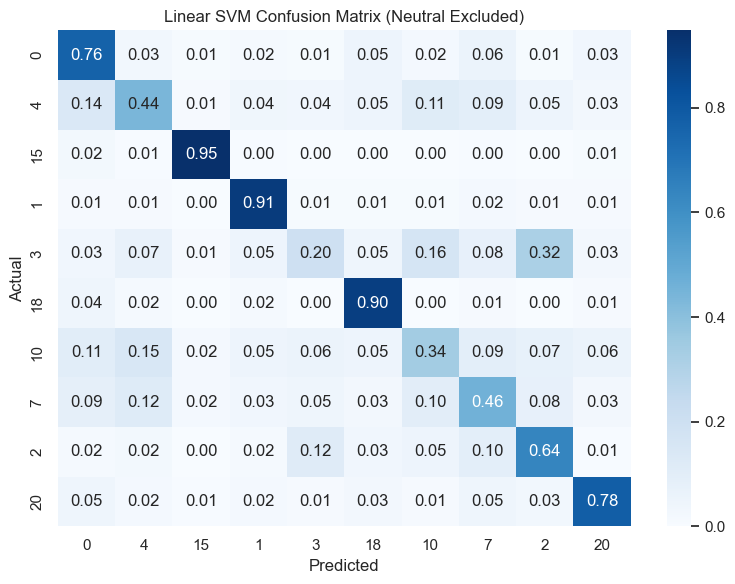

Top Confused Class Pairs:
23 ➜ 5: 27.27% of the time
16 ➜ 25: 20.00% of the time
19 ➜ 7: 19.05% of the time
Naive Bayes - Macro F1: 0.302


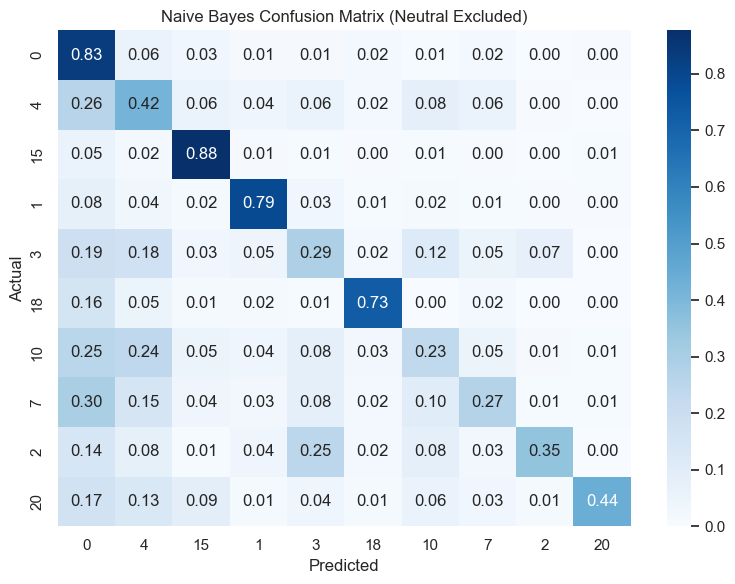

Top Confused Class Pairs:
19 ➜ 0: 42.86% of the time
13 ➜ 0: 42.19% of the time
21 ➜ 0: 38.46% of the time


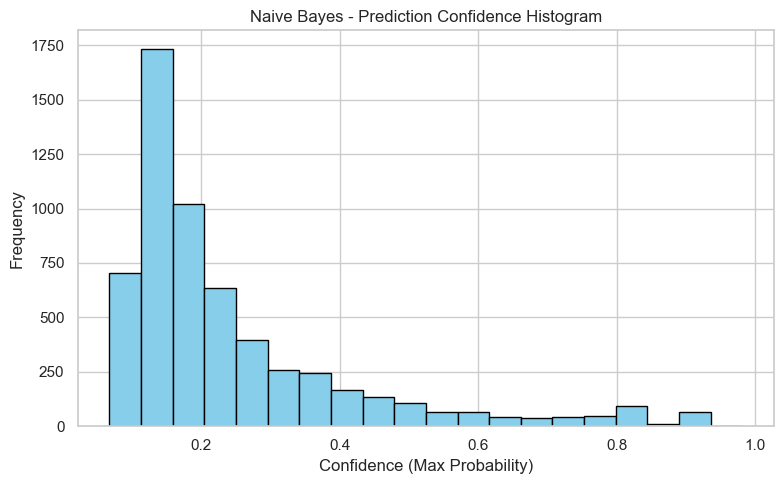

/Users/Daniel/anaconda3/envs/emotion_env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic Regression - Macro F1: 0.398


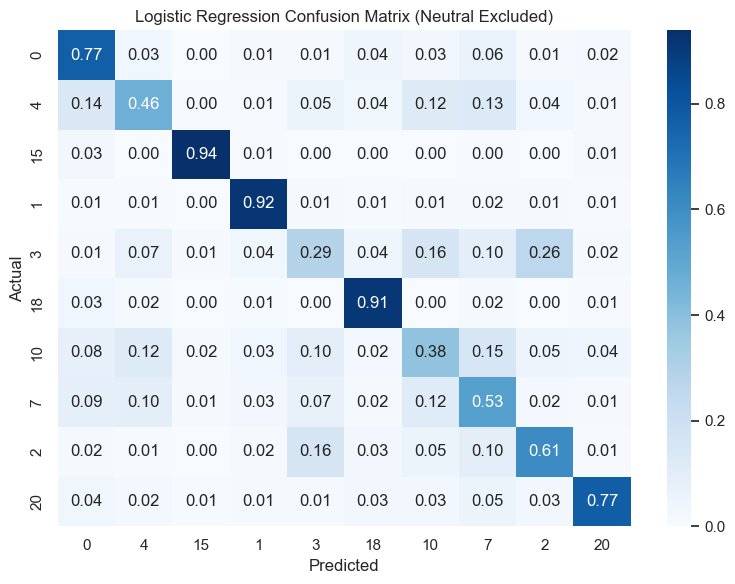

Top Confused Class Pairs:
23 ➜ 5: 27.27% of the time
19 ➜ 7: 19.05% of the time
21 ➜ 0: 15.38% of the time


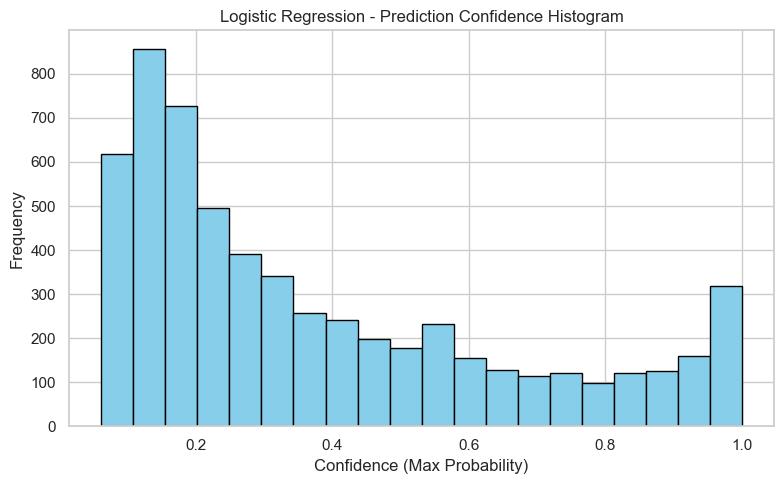

MLP Classifier - Macro F1: 0.319


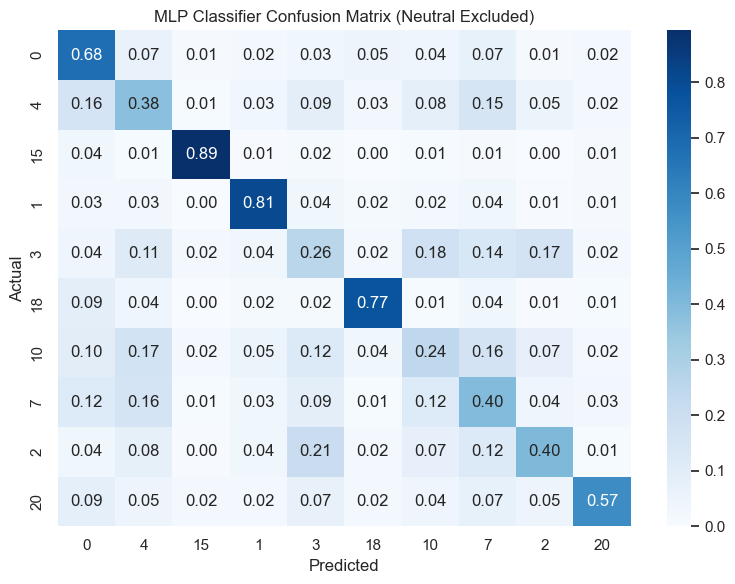

Top Confused Class Pairs:
16 ➜ 25: 30.00% of the time
21 ➜ 2: 23.08% of the time
23 ➜ 5: 22.73% of the time


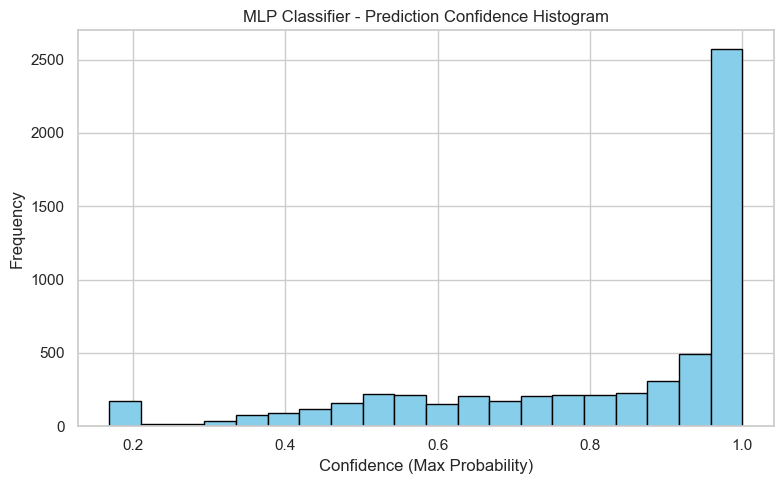

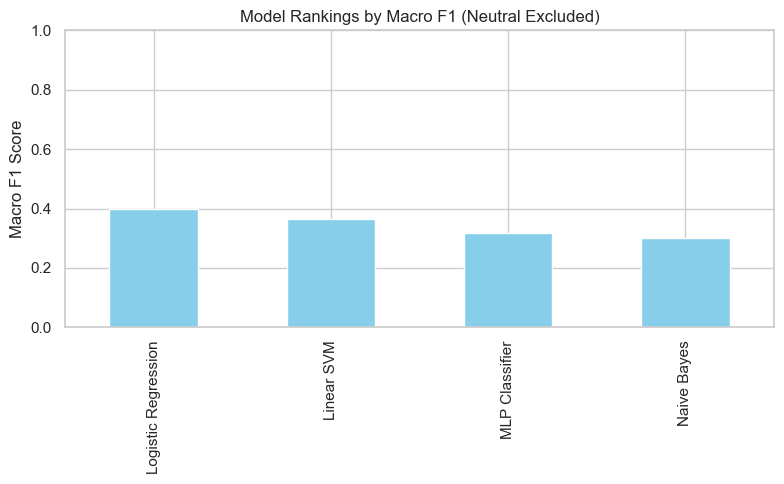

NameError: name 'y_test' is not defined

In [8]:
# Pipeline B: Neutral label not included
df_no_neutral = df_single[df_single['label_name'] != 'neutral']
results_no_neutral = train_eval_pipeline(df_no_neutral, title="Neutral Excluded")
print_most_confused_pairs(y_test, preds, label_names)

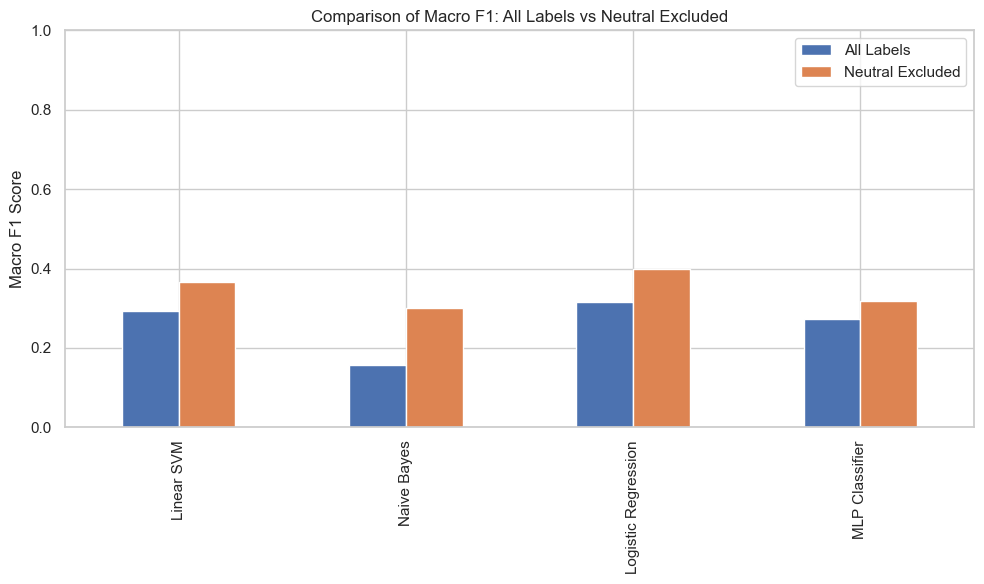

In [9]:
# Combine results for comparison
comparison_df = pd.DataFrame({
    'All Labels': df_results_all['Macro F1'],
    'Neutral Excluded': results_no_neutral['Macro F1']
})

comparison_df.plot.bar(figsize=(10,6))
plt.ylabel('Macro F1 Score')
plt.title('Comparison of Macro F1: All Labels vs Neutral Excluded')
plt.ylim(0,1)
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()